In [14]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [10]:
# import data
df = pd.read_excel("Roster.xlsx", index_col=None)

# reformat data into dictionaries
from collections import defaultdict
rosters = defaultdict(list)
for (drafter, candidate) in zip(df["Drafter"],df["Candidate"]):
    key = drafter
    rosters[key].append(candidate)

drop_list = defaultdict(datetime.date)
for (candidate, drop_date) in zip(df["Candidate"],df["Date Dropped"]):
    drop_list[candidate] = drop_date

data = {}
for drafter in rosters:
    for candidate in rosters[drafter]:
        if(drop_list[candidate]=="-"):
            print(candidate,"has not dropped")
        else:
            print(candidate,"dropped on",drop_list[candidate])





Delaney has not dropped
Bullock dropped on 2019-12-02 00:00:00
Klobuchar has not dropped
Gillibrand dropped on 2019-08-28 00:00:00
Sanders has not dropped
Mouton dropped on 2019-08-23 00:00:00
Bennet has not dropped
Beto dropped on 2019-11-01 00:00:00
Booker dropped on 2020-01-13 00:00:00
Ryan dropped on 2019-10-24 00:00:00
Gravel dropped on 2019-08-06 00:00:00
Biden has not dropped
Harris dropped on 2019-12-03 00:00:00
Hickenlooper dropped on 2019-08-15 00:00:00
Williamson dropped on 2020-01-10 00:00:00
Yang has not dropped
Castro dropped on 2020-01-02 00:00:00
Blasio dropped on 2019-09-20 00:00:00
Gabbard has not dropped
Warren has not dropped
Buttigieg has not dropped
Inslee dropped on 2019-08-21 00:00:00


In [11]:
start_date = datetime.date(2019, 6, 15)
delta = (datetime.date.today() - start_date).days
print("{0} days have elapsed since the start of the draft".format(delta))

# Total number of points on a per day basis for a candidate that has not dropped
ideal_points = np.array(range(delta))+1
drafter_points = {} # dictionary to hold point totals
for (drafter, candidate) in zip(df["Drafter"],df["Candidate"]):
    if(drop_list[candidate]=="-"):
        drafter_points[drafter] = drafter_points.get(drafter, np.zeros(delta)) + ideal_points
    else:
        time_in_race = (drop_list[candidate].date() - start_date).days
        temp_points = ideal_points.copy()
        temp_points[-1:time_in_race-1:-1] = time_in_race
        drafter_points[drafter] = drafter_points.get(drafter, np.zeros(delta)) + temp_points


213 days have elapsed since the start of the draft


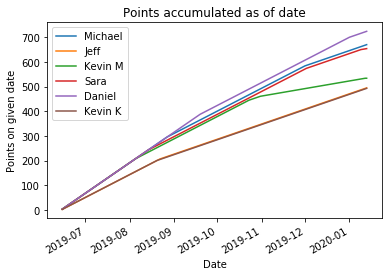

<Figure size 12000x9000 with 0 Axes>

In [17]:
dates = [start_date + datetime.timedelta(days=i) for i in range(delta)]
for drafter in drafter_points:
    plt.plot(dates, drafter_points[drafter]);

plt.gcf().autofmt_xdate();
plt.title("Points accumulated as of date");
plt.xlabel("Date");
plt.ylabel("Points on given date");
plt.legend(drafter_points.keys());
plt.figure(figsize=(40, 30), dpi=300);